In [1]:
import os
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from recsys.models import FM
from recsys.data.movielens import MovielensDataset
from recsys.utils.metrics import evaluate
from recsys.utils import recommender, visualizer

In [2]:
with open("movielens/processed/num_sparse_features.json", "r") as f:
    num_sparse_features = json.load(f)
    
with open("movielens/processed/dense_features.json", "r") as f:
    dense_features = json.load(f)
    
with open("movielens/processed/experiment_group.json", "r") as f:
    experiment_group = json.load(f)
experiment_group[FM.model_name] = []

train = pd.read_parquet("movielens/processed/train.parquet")
test = pd.read_parquet("movielens/processed/test.parquet")

In [3]:
# Training Hyperparameter
batch_size = 64
latent_dim = 16
lr = 1e-3
epochs = 10

# Define Dataset
train_ds = MovielensDataset(train, list(num_sparse_features.keys()), dense_features)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = MovielensDataset(test, list(num_sparse_features.keys()), dense_features)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=test["item_id"].nunique(), shuffle=False)

device = torch.device("cpu")
model = FM(num_sparse_features, dense_features, latent_dim)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

FactorizationMachine(
  (linear_sparse): ModuleDict(
    (user_id): Embedding(943, 1)
    (item_id): Embedding(1682, 1)
    (gender): Embedding(2, 1)
    (occupation): Embedding(21, 1)
    (genre): Embedding(19, 1)
  )
  (linear_dense): Linear(in_features=1, out_features=1, bias=True)
  (sparse_arch): ModuleDict(
    (user_id): Embedding(943, 16)
    (item_id): Embedding(1682, 16)
    (gender): Embedding(2, 16)
    (occupation): Embedding(21, 16)
    (genre): Embedding(19, 16)
  )
  (dense_arch): Linear(in_features=1, out_features=16, bias=True)
)


Epoch 1/10: 100%|█| 5747/5747 [00:18<00:00, 303.84it/s, auc=0.0000, logloss=0.89
Epoch 2/10: 100%|█| 5747/5747 [00:18<00:00, 305.11it/s, auc=0.5557, logloss=0.57
Epoch 3/10: 100%|█| 5747/5747 [00:18<00:00, 304.69it/s, auc=0.6465, logloss=0.29
Epoch 4/10: 100%|█| 5747/5747 [00:18<00:00, 303.44it/s, auc=0.7281, logloss=0.35
Epoch 5/10: 100%|█| 5747/5747 [00:18<00:00, 316.50it/s, auc=0.7842, logloss=0.44
Epoch 6/10: 100%|█| 5747/5747 [00:17<00:00, 331.94it/s, auc=0.8207, logloss=0.26
Epoch 7/10: 100%|█| 5747/5747 [00:16<00:00, 345.60it/s, auc=0.8479, logloss=0.50
Epoch 8/10: 100%|█| 5747/5747 [00:16<00:00, 353.78it/s, auc=0.8714, logloss=0.25
Epoch 9/10: 100%|█| 5747/5747 [00:15<00:00, 370.90it/s, auc=0.8919, logloss=0.2]
Epoch 10/10: 100%|█| 5747/5747 [00:13<00:00, 411.02it/s, auc=0.9078, logloss=0.2


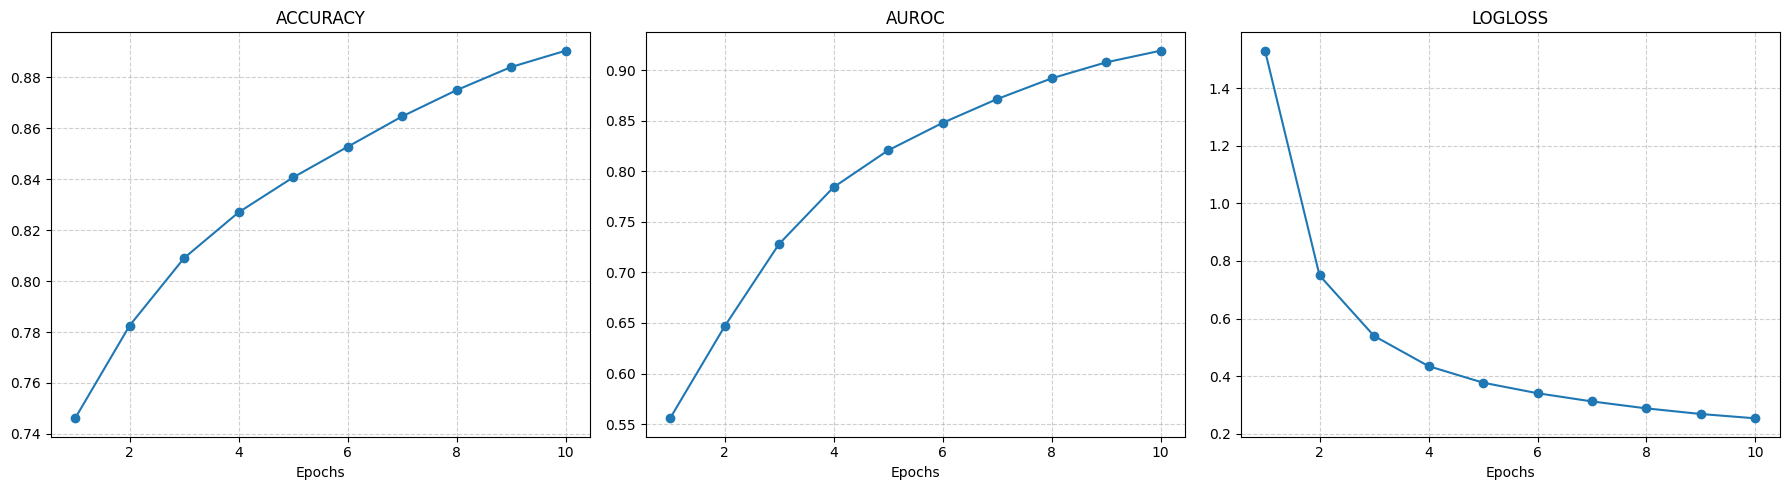

In [4]:
history = recommender.train(model, train_loader, optimizer, device, epochs)
visualizer.plot_history(history)

Recommend (fm): 100%|███████████| 943/943 [00:09<00:00, 102.40it/s, user_id=942]


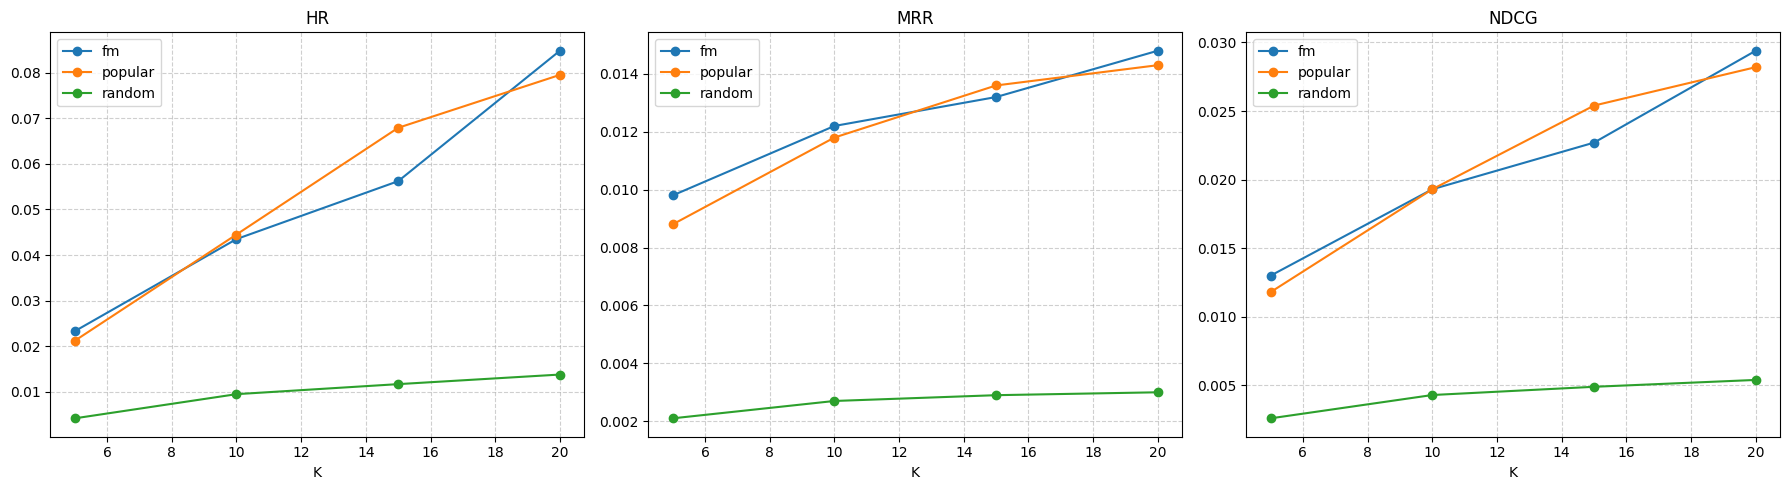

In [5]:
user_recommendations = recommender.inference(model, device, test_loader)

ks = [5, 10, 15, 20]
_test = test[test["rating"]==1]
recommendations = {
    "popular": np.array(experiment_group["popular"]),
    "random": np.array(experiment_group["random"]),
    model.model_name: user_recommendations
}
results = evaluate(_test, recommendations, ks)
visualizer.plot_metrics(results)